In [ ]:
!pip install seaborn
import boto3
import pandas as pd
from io import BytesIO
from io import StringIO

# Initialize a boto3 client with your AWS credentials
# Access key ID & Secret access key shared in your mail
s3_client = "secret"

bucket_name = 'datathon-3.0'

file_list = ["Q1-customers.csv","Q1-submission.csv","Q2-new-products.csv","Q2-submission.csv","Q4A-submission.csv","Q4B-submission.csv","TBL_CUSTOMER_PROFILE.csv", "TBL_PACK_PURCHASE.csv","TBL_PRODUCT_CATALOGUE.csv","TBL_DATA_CONSUMPTION.csv"]
for i, file in enumerate(file_list):
    print(i, file)


profile = file_list[6]
response = s3_client.get_object(Bucket=bucket_name, Key=profile)
profile = pd.read_csv(BytesIO(response['Body'].read()))

purchase = file_list[7]
response = s3_client.get_object(Bucket=bucket_name, Key=purchase)
purchase = pd.read_csv(BytesIO(response['Body'].read()))

catal = file_list[8]
response = s3_client.get_object(Bucket=bucket_name, Key=catal)
catal = pd.read_csv(BytesIO(response['Body'].read()))
catal['SERVICE_TYPE'] = catal['SERVICE_TYPE'].map({'Premium':1, 'Standard':0})
catal['PRODUCT_STATUS'] = catal['PRODUCT_STATUS'].map({'Continue':1, 'Discontinue':0, 'New':2})
catal['PAYMENT_METHOD'] = catal['PAYMENT_METHOD'].map({'Credit Card':3, 'Mobile Walet':2, 'Digital Wallets':1, 'Cash':0})
catal['per_GB'] = catal['PACK_PRICE'] / catal['DATA_VOL_GB']
new = catal[catal['PRODUCT_STATUS'] == 2].reset_index(drop=True)
old = catal[catal['PRODUCT_STATUS'] != 2].reset_index(drop=True)

cons = file_list[9]
response = s3_client.get_object(Bucket=bucket_name, Key=cons)
cons = pd.read_csv(BytesIO(response['Body'].read()))

prod_2 = file_list[2]
response = s3_client.get_object(Bucket=bucket_name, Key=prod_2)
prod_2 = pd.read_csv(BytesIO(response['Body'].read()))

sample_2 = file_list[3]
response = s3_client.get_object(Bucket=bucket_name, Key=sample_2)
sample_2 = pd.read_csv(BytesIO(response['Body'].read()))

0 Q1-customers.csv
1 Q1-submission.csv
2 Q2-new-products.csv
3 Q2-submission.csv
4 Q4A-submission.csv
5 Q4B-submission.csv
6 TBL_CUSTOMER_PROFILE.csv
7 TBL_PACK_PURCHASE.csv
8 TBL_PRODUCT_CATALOGUE.csv
9 TBL_DATA_CONSUMPTION.csv


In [15]:
### checking shape of the datasets
profile.shape, purchase.shape, catal.shape, cons.shape

((342643, 14), (1208710, 4), (2049, 8), (23375373, 4))

### Merging datasets and addition of features

In [16]:
df = purchase.copy()
df = pd.merge(df, catal, on='PACK_ID', how='left')
df = df[(df['VALIDITY'] == 7) | (df['VALIDITY'] == 30)].reset_index(drop=True)
df['EVENT_DATE'] = pd.to_datetime(df['EVENT_DATE'], format='%Y%m%d')
df['month'] = df['EVENT_DATE'].dt.month

a = df.groupby('PACK_ID')['HITS'].sum()
df = df.merge(a.rename('monthly_hit'), on='PACK_ID', how='left')

month_uniq = df.groupby('PACK_ID')['month'].nunique()
df = df.merge(month_uniq.rename('month_uniq'), on='PACK_ID', how='left')
df['monthly_hit'] = df['monthly_hit'] / df['month_uniq']

import numpy as np
df['monthly_hit'] = np.ceil(df['monthly_hit'])

df 

,EVENT_DATE,CUSTOMER_ID,PACK_ID,HITS,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,per_GB,month,monthly_hit,month_uniq
0,2019-07-03,CD20EDFC8000A7,1756,1,1,0,468,30,8.0,0,58.500000,7,1.0,1
1,2019-05-22,CD1F932E0A89C1,1524,1,0,0,994,30,168.0,0,5.916667,5,441.0,2
2,2019-05-22,CD201715F62164,1524,1,0,0,994,30,168.0,0,5.916667,5,441.0,2
3,2019-06-23,CD1F7B4DD83C5B,1524,1,0,0,994,30,168.0,0,5.916667,6,441.0,2
4,2019-05-23,CD1F7BD12742B8,1524,1,0,0,994,30,168.0,0,5.916667,5,441.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775952,2019-08-04,CD1FA871ADE84D,28,1,0,2,798,30,80.0,0,9.975000,8,439.0,5
775953,2019-09-18,CD1FACB2FDD94D,28,1,0,2,798,30,80.0,0,9.975000,9,439.0,5
775954,2019-06-12,CD1FAE136CC024,28,1,0,2,798,30,80.0,0,9.975000,6,439.0,5
775955,2019-06-28,CD1FC017C11310,28,1,0,2,798,30,80.0,0,9.975000,6,439.0,5


## Visualization

<Axes: >

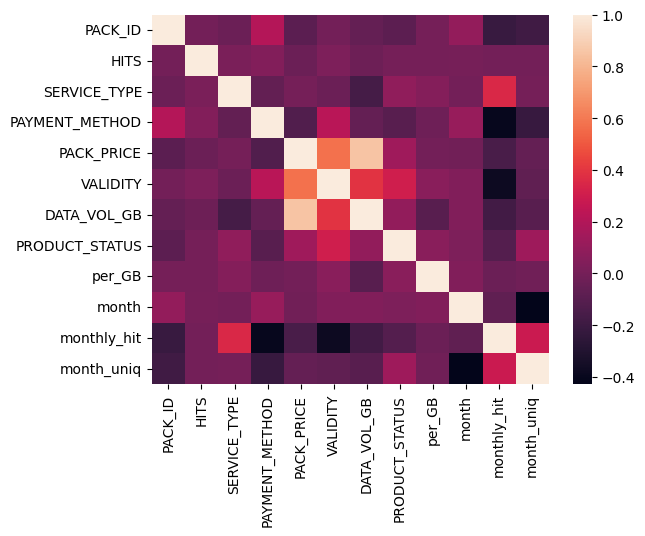

In [17]:
import seaborn as sns
corr_matrix = df.corr(numeric_only=True)

sns.heatmap(corr_matrix)

### Pack Price and Data volume are two of the most correlated features as it can be seen from the heatmap

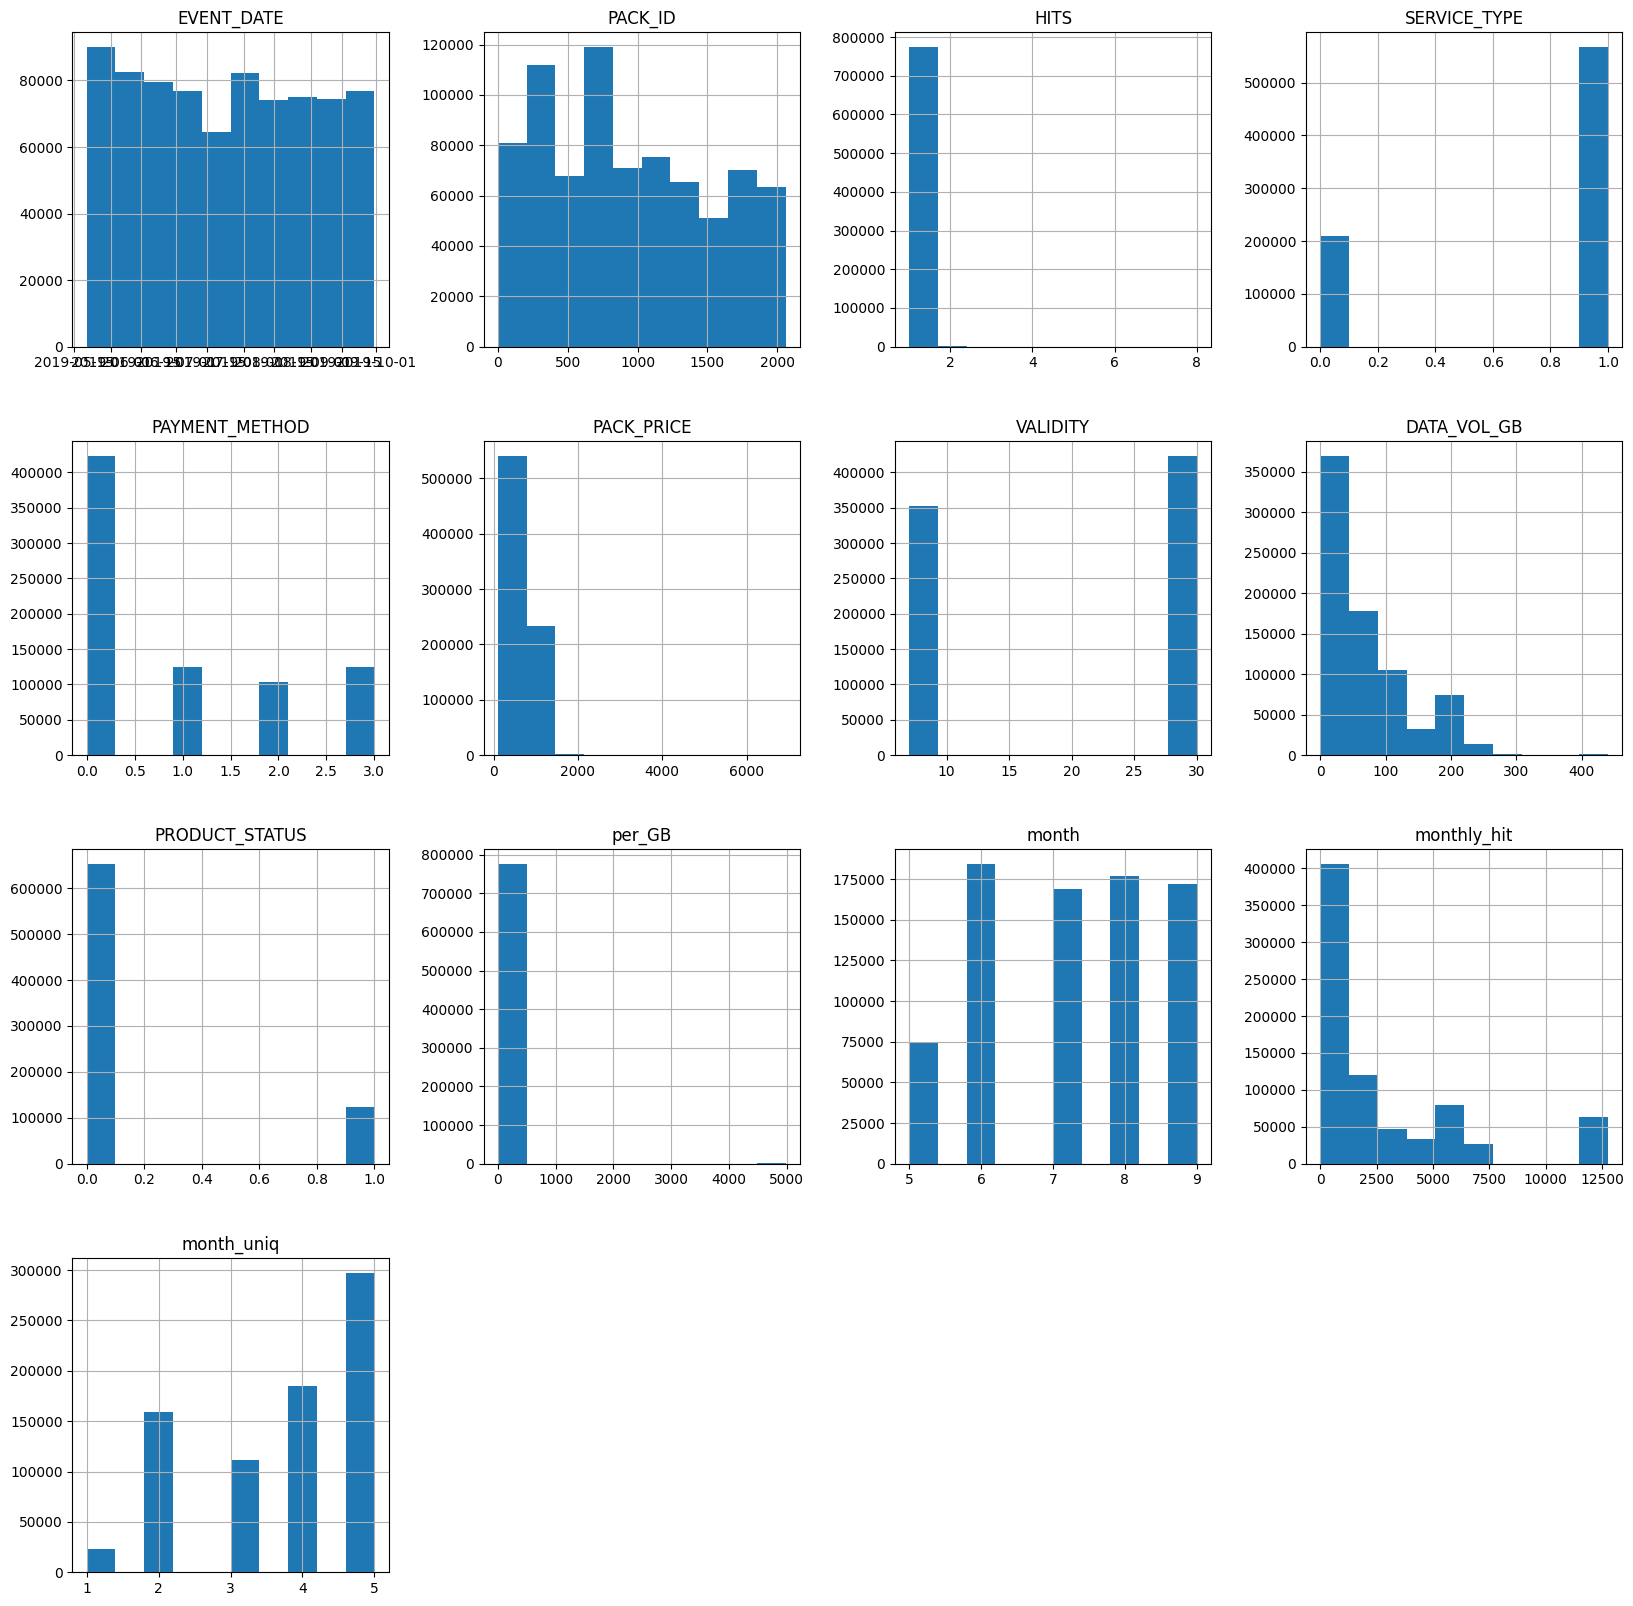

In [18]:
df.hist(figsize=(20,20));

Text(0, 0.5, 'DATA_VOL_GB')

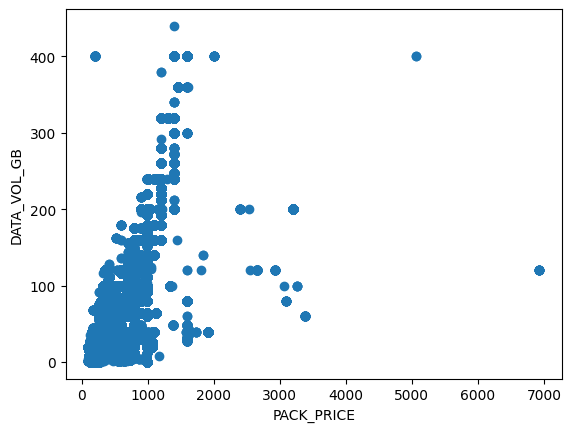

In [19]:
import matplotlib.pyplot as plt
plt.scatter(df['PACK_PRICE'], df['DATA_VOL_GB']);
plt.xlabel('PACK_PRICE')
plt.ylabel('DATA_VOL_GB')

Text(0, 0.5, 'DATA_VOL_GB')

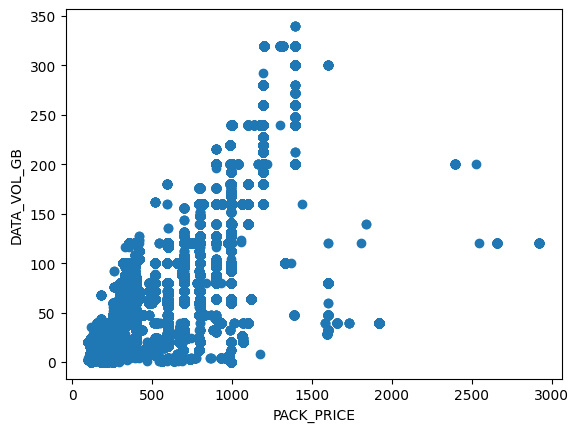

In [20]:
df = df[(df['PACK_PRICE'] < 3000) & (df['DATA_VOL_GB']<350)]
plt.scatter(df['PACK_PRICE'], df['DATA_VOL_GB'], );
plt.xlabel('PACK_PRICE')
plt.ylabel('DATA_VOL_GB')


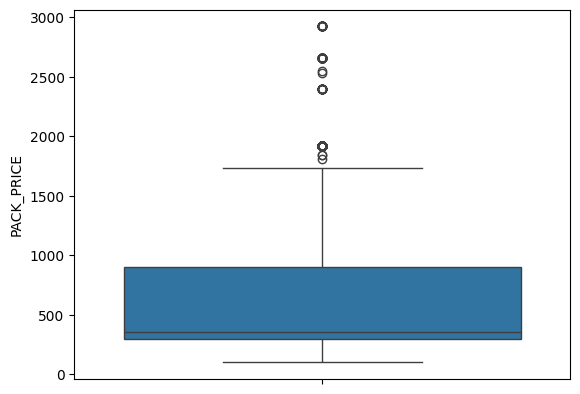

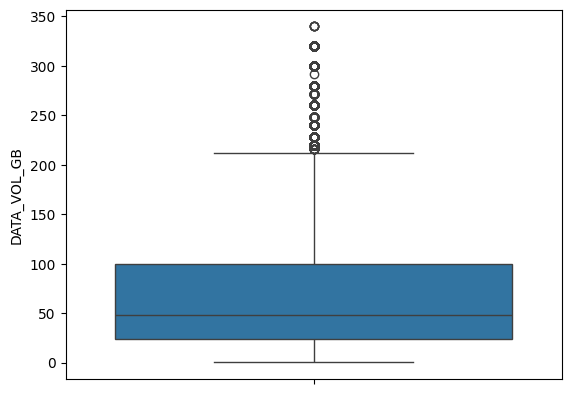

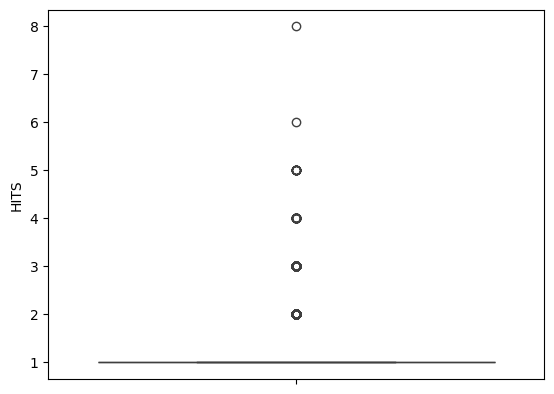

In [21]:
sns.boxplot(df['PACK_PRICE']);
plt.figure()
sns.boxplot(df['DATA_VOL_GB']);
plt.figure()
sns.boxplot(df['HITS']);

# KNN model to Map old packs to new

In [22]:
from sklearn.neighbors import NearestNeighbors

train = df[catal.columns].reset_index(drop=True).drop_duplicates(ignore_index=True)
test = catal[catal['PACK_ID'].isin(prod_2['PACK_ID'])].reset_index(drop=True)

### Scaling the data 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

a = train['PACK_ID']
scaled_data = sc.fit_transform(train)
train = pd.DataFrame(scaled_data, columns=train.columns)
train['PACK_ID'] = a

a = test['PACK_ID']
scaled_data = sc.fit_transform(test)
test = pd.DataFrame(scaled_data, columns=test.columns)
test['PACK_ID'] = a

### model fitting
model = NearestNeighbors(n_neighbors=5)
model.fit(train.drop('PACK_ID', axis=1))
dist, ind = model.kneighbors(test.drop('PACK_ID', axis=1))
ind

array([[ 411,  478, 1045,  763,  150],
       [ 933,  586,  515,   50, 1116],
       [ 351,  324,  352,  471,  356],
       [ 853,  363,  849,  906,  854],
       [ 411, 1045,  150,  478,  525],
       [ 351,  953,   36, 1121,  356],
       [ 106,   85,  213, 1109,  182],
       [ 763,  661,  421, 1024,  429],
       [ 351,  324,  356,  352,  401],
       [ 351,  605,  205,   23,  919],
       [ 763,  408, 1031,  661,  421],
       [  48,   11,  437,  898,  928],
       [ 351,  324,  471,  352,  190],
       [1137,  150,  879,  960,  426],
       [ 853, 1104,  607,  224,  388],
       [1031,  408,  888,  974,  763],
       [ 140,  570, 1034,  351,  360],
       [1063,  395,  601,  697,  600],
       [ 696,  804,  116,  935,  569],
       [ 351,  324,  352,  471,  356]])

### Creating the submission csv file 

In [23]:
import numpy as np
test['HITS'] = 0
min = 10000
max = 0
for i in range(len(test)):
    temp = df.iloc[ind[i]]
    temp = temp['monthly_hit'].mean()
    test.loc[i, 'HITS'] = temp
    
test = test[['PACK_ID', 'HITS']]

test['HITS'] = np.ceil(test['HITS'])
test['HITS'] = test['HITS'].astype(int)
test.to_csv('Q2-submission.csv', index=False)